# Library Imports and Setup

In [1]:
# Install or upgrade the numexpr package, which is used by pandas for efficient numerical expressions
!pip install --upgrade numexpr

# Install the mxnet library, which is a deep learning framework used for loading and manipulating the KMeans model parameters
!pip install mxnet

# AWS SageMaker and Services
import sagemaker                          # Main SageMaker library for ML models
from sagemaker import get_execution_role  # Function to obtain the IAM role for SageMaker
from sagemaker import KMeans              # KMeans algorithm for clustering
from sagemaker.image_uris import retrieve # Function to retrieve container image URIs
from sagemaker.model import Model         # SageMaker Model class for deploying ML models
from sagemaker.predictor import Predictor # SageMaker Predictor class for making predictions
from sagemaker.serializers import CSVSerializer # Serializer for converting data to CSV format
import boto3                              # AWS SDK for Python
from botocore.exceptions import ClientError # Exception handling for Boto3

# Data Manipulation
import pandas as pd                       # Data manipulation and analysis library
import numpy as np                        # Numerical computing library

# Data Visualization
import matplotlib.pyplot as plt           # Plotting library
import seaborn as sns                     # Statistical data visualization library

# Additional Libraries
import tarfile                            # Reading and writing tar archives
import mxnet as mx                        # Deep learning framework
import datetime                           # Date and time manipulation
import json                               # Library for parsing and manipulating JSON data
import time                               # Import the time library for sleep

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# SageMaker Setup and Configuration

In [2]:
# Create a SageMaker session
sagemaker_session = sagemaker.Session()   # Initialize a SageMaker session

# Retrieve the execution role and AWS region name
role = get_execution_role()               # Get the IAM role for SageMaker
region = sagemaker_session.boto_region_name # Obtain the AWS region name

# Create clients for S3 and SageMaker
s3_client = boto3.client('s3')            # Create an S3 client
sagemaker_client = boto3.client('sagemaker') # Create a SageMaker client

# Specify the image URI for the KMeans model
image_uri = retrieve('kmeans', region)    # Retrieve the image URI for KMeans algorithm

# Define the default S3 bucket and the data storage prefix
bucket = sagemaker_session.default_bucket() # Get the default S3 bucket
prefix = 'sagemaker/mall/kmeans-one'      # Set the data storage prefix

# Print the execution role ARN and AWS region name
print("Execution Role ARN:", role)        # Print the execution role ARN
print("AWS Region:", region)              # Print the AWS region name

Execution Role ARN: arn:aws:iam::381492163284:role/LabRole
AWS Region: us-east-1


# Load and preprocess the dataset

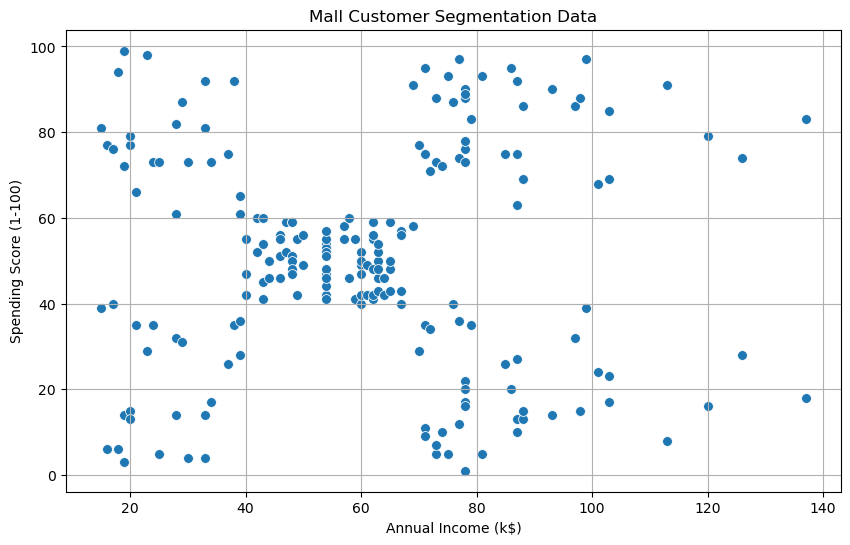

In [3]:
# Load and preprocess the dataset
df_mall = pd.read_csv('Mall_Customers.csv')  # Load the dataset
df_mall = df_mall[['Annual Income (k$)', 'Spending Score (1-100)']] # Select relevant columns
data_np = df_mall.values.astype('float32')   # Convert data to NumPy array of type float32

# Save and upload the preprocessed data to S3
df_mall.to_csv('mall_data.csv', index=False) # Save preprocessed data to a CSV file
data_uri = sagemaker_session.upload_data('mall_data.csv', key_prefix='kmeans-mall') # Upload data to S3

# Plot the data before training using Seaborn
plt.figure(figsize=(10, 6))                 # Set the figure size
sns.scatterplot(x='Annual Income (k$)', y='Spending Score (1-100)', data=df_mall, s=50) # Scatter plot with Seaborn
plt.title('Mall Customer Segmentation Data') # Set the plot title
plt.xlabel('Annual Income (k$)')            # Set the x-axis label
plt.ylabel('Spending Score (1-100)')        # Set the y-axis label
plt.grid(True)                              # Enable the grid
plt.show()                                  # Display the plot


# KMeans Model Training

In [4]:
# Train KMeans models for different values of K in parallel
k_values = range(2, 8)                          # Specify the range of K values to try
model_paths = []                                # List to store the paths to the trained models
training_jobs = []                              # List to store the names of the training jobs along with the value of K

for k in k_values:                              # Iterate over each K value
    # Define the job name for the training job
    job_name = f'kmeans-mall-k-{k}'
    output_path = f's3://{sagemaker_session.default_bucket()}/kmeans-mall/one/output' # Define the output path in S3
    
    kmeans = KMeans(                            # Initialize the KMeans estimator
        sagemaker_session=sagemaker_session,    # Specify the SageMaker session
        role=role,                              # Specify the IAM role ARN used by SageMaker
        instance_count=1,                       # Specify the number of instances to use for training
        instance_type='ml.m5.large',            # Specify the instance type for training
        k=k,                                    # Specify the number of clusters
        output_path=output_path,                # Specify the S3 path for output data
        job_name=job_name,                      # Specify the job name
        feature_dim=2                           # Specify the number of features in the input data
    )
    
    kmeans.fit(kmeans.record_set(data_np), wait=False)  # Start the training job asynchronously
    training_jobs.append((k, kmeans.latest_training_job.name)) # Append the value of K and the training job name to the list

# Wait for all training jobs to complete and collect the model paths
for k, job_name in training_jobs:                          # Iterate over each training job
    sagemaker_client.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name) # Wait for the job to complete
    training_job_description = sagemaker_client.describe_training_job(TrainingJobName=job_name) # Describe the training job
    model_s3_uri = training_job_description['ModelArtifacts']['S3ModelArtifacts'] # Get the model's S3 URI
    model_paths.append((k, model_s3_uri))                    # Append the value of K and the model's S3 URI to the list


INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-11-11-53-14-896
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker:Creating training-job with name: kmeans-2024-03-11-11-53-15-532
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris:Ignoring unnecessary instance type: None.
INFO:sagemaker.image_uris:Same images used for training and inference. Defaulting to image scope: inference.
INFO:sagemaker.image_uris

# Model Evaluation

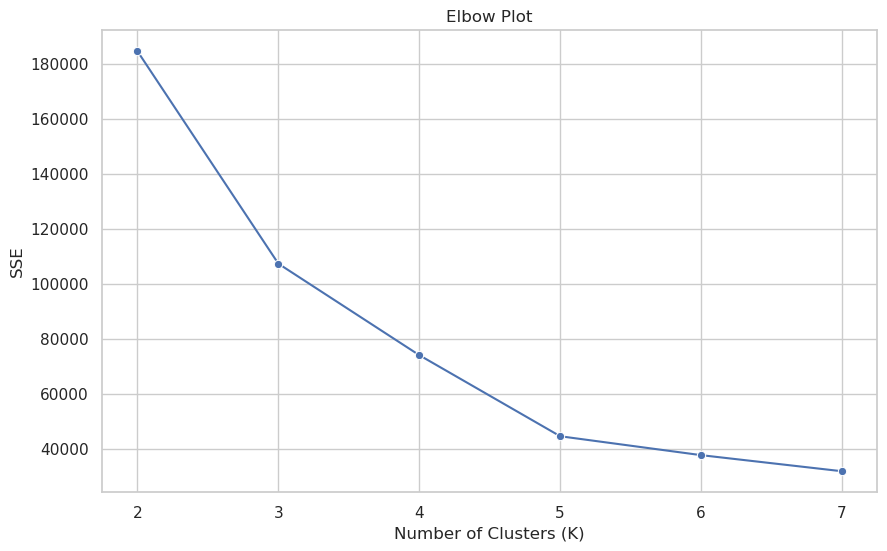

In [5]:
# Extract SSE values from the trained models
sse_values = []  # List to store SSE values for each model

for k, model_path in model_paths:  # Iterate over each model path
    try:
        # Define the local path to save the model
        local_path = f'/tmp/model-k-{k}.tar.gz'
        # Download the model from S3 to the local path
        s3_client.download_file(sagemaker_session.default_bucket(), model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)
        
        # Extract the model files from the tar archive
        with tarfile.open(local_path) as tar:
            tar.extractall(path=f'/tmp/k-{k}')
        
        # Load the KMeans model parameters
        kmeans_model_params = mx.ndarray.load(f'/tmp/k-{k}/model_algo-1')
        # Extract the centroids from the model parameters
        centroids = kmeans_model_params[0].asnumpy()
        
        # Calculate the distances between each data point and the centroids
        distances = np.sqrt(((data_np - centroids[:, np.newaxis])**2).sum(axis=2))
        # Determine the closest centroid for each data point
        closest_centroids = np.argmin(distances, axis=0)
        # Calculate the SSE for the current model
        sse = np.sum((data_np - centroids[closest_centroids])**2)
        
        # Append the SSE value to the list
        sse_values.append(sse)
    except Exception as e:  # Catch any exceptions during the process
        print(f'Error processing model for K={k}: {e}')  # Print the error message

# Plot the Elbow Plot
sns.set_theme(style="whitegrid")  # Set the Seaborn theme for the plots

plt.figure(figsize=(10, 6))  # Set the figure size
sns.lineplot(x=[k for k, _ in model_paths], y=sse_values, marker='o')  # Plot the Elbow Plot using Seaborn
plt.title('Elbow Plot')  # Set the plot title
plt.xlabel('Number of Clusters (K)')  # Set the x-axis label
plt.ylabel('SSE')  # Set the y-axis label
plt.xticks([k for k, _ in model_paths])  # Set the x-axis ticks
plt.show()  # Display the plot


In [6]:
# Specify the best K value
best_k = 5

# Find the model path for the best K value
best_model_path = next(path for k, path in model_paths if k == best_k)

# Define the local path to save the best model
local_path = '/tmp/best_model.tar.gz'

# Download the best model from S3 to the local path
s3_client.download_file(sagemaker_session.default_bucket(), best_model_path.replace(f's3://{sagemaker_session.default_bucket()}/', ''), local_path)

# Extract the model parameters
with tarfile.open(local_path) as tar:
    tar.extractall(path='/tmp/best_model')

# Load the best KMeans model parameters
kmeans_best_params = mx.ndarray.load('/tmp/best_model/model_algo-1')
centroids_best = kmeans_best_params[0].asnumpy()  # Extract the centroids

# Calculate the closest centroids for each data point
distances_best = np.sqrt(((data_np - centroids_best[:, np.newaxis])**2).sum(axis=2))
cluster_labels = np.argmin(distances_best, axis=0)  # Assign clusters

# Add cluster labels to the DataFrame
df_mall['Cluster'] = cluster_labels

# Calculate and print the model metrics
sse_best = np.sum((data_np - centroids_best[cluster_labels])**2)
print(f"Model Metrics for Best K ({best_k}):")
print(f"SSE: {sse_best}")


Model Metrics for Best K (5):
SSE: 44652.0625


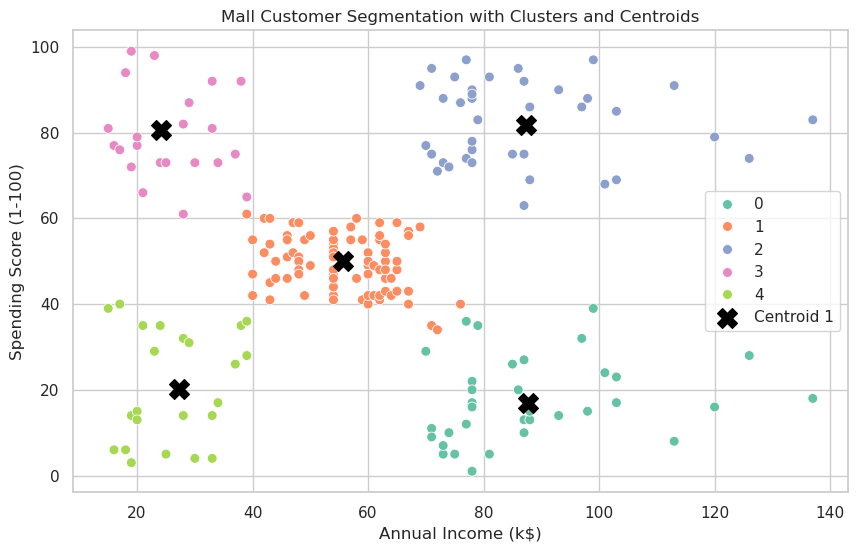

In [7]:
# Set the Seaborn theme for the plots
sns.set_theme(style="whitegrid")

# Plot the data points with cluster assignments
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_mall, x='Annual Income (k$)', y='Spending Score (1-100)', hue='Cluster', palette='Set2', s=50)

# Plot the centroids
for i, centroid in enumerate(centroids_best):
    plt.scatter(centroid[0], centroid[1], s=200, c='black', marker='X', label=f'Centroid {i+1}' if i == 0 else None)

plt.title('Mall Customer Segmentation with Clusters and Centroids')  # Set the plot title
plt.xlabel('Annual Income (k$)')  # Set the x-axis label
plt.ylabel('Spending Score (1-100)')  # Set the y-axis label
plt.legend()  # Show the legend
plt.show()  # Display the plot

# Model Deployment to SageMaker Endpoint

In [8]:
# Specify the endpoint name
endpoint_name = 'mall-kmeans-one'

# Specify the endpoint configuration name
endpoint_config_name = 'mall-kmeans-one'

# Create a SageMaker client
sagemaker_client = boto3.client('sagemaker')

In [9]:
# Check if the endpoint configuration already exists
try:
    sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
    print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)

    # Wait for the endpoint configuration to be deleted
    while True:
        try:
            sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
            print("Waiting for endpoint configuration to be deleted...")
            time.sleep(5)  # Wait for 5 seconds before checking again
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
                break  # Exit the loop if the endpoint configuration is deleted
            else:
                raise

except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
    else:
        raise


Endpoint configuration "mall-kmeans-one" already exists. Deleting...
Endpoint configuration "mall-kmeans-one" deleted.


In [10]:
# Check if the endpoint already exists
try:
    sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
    print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
    sagemaker_client.delete_endpoint(EndpointName=endpoint_name)

    # Wait for the endpoint to be deleted
    while True:
        try:
            sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
            print("Waiting for endpoint to be deleted...")
            time.sleep(5)  # Wait for 5 seconds before checking again
        except ClientError as e:
            if e.response['Error']['Code'] == 'ValidationException':
                print(f'Endpoint "{endpoint_name}" deleted.')
                break  # Exit the loop if the endpoint is deleted
            else:
                raise

except ClientError as e:
    if e.response['Error']['Code'] == 'ValidationException':
        print(f'Endpoint "{endpoint_name}" does not exist.')
    else:
        raise


Endpoint "mall-kmeans-one" already exists. Deleting...
Waiting for endpoint to be deleted...
Endpoint "mall-kmeans-one" deleted.


In [11]:
# Find the S3 URI for the best model
best_model_s3_uri = next(path for k, path in model_paths if k == best_k)

# Create a SageMaker Model object with the best model artifacts
best_model = Model(model_data=best_model_s3_uri,
                   image_uri=image_uri,
                   role=role,
                   sagemaker_session=sagemaker_session)

# Deploy the model as an endpoint
best_model.deploy(initial_instance_count=1, instance_type='ml.t2.medium', endpoint_name=endpoint_name)

INFO:sagemaker:Creating model with name: kmeans-2024-03-11-11-57-28-681
INFO:sagemaker:Creating endpoint-config with name mall-kmeans-one
INFO:sagemaker:Creating endpoint with name mall-kmeans-one


-----------------!

# Cluster Associations and Centroids

In [ ]:
# Create a Predictor object for the deployed endpoint
predictor = Predictor(endpoint_name=endpoint_name, serializer=CSVSerializer())

while True:
    # Prompt for Annual Income and Spending Score
    annual_income = input("Enter Annual Income (k$) or type 'quit' to exit: ")
    if annual_income.lower() == 'quit':
        break
    spending_score = input("Enter Spending Score (1-100) or type 'quit' to exit: ")
    if spending_score.lower() == 'quit':
        break

    # Prepare the data for prediction
    data = f'{annual_income},{spending_score}\n'

    # Make prediction
    response = predictor.predict(data)

    # Parse the prediction response
    response_json = json.loads(response)
    cluster = response_json['predictions'][0]['closest_cluster']
    distance = response_json['predictions'][0]['distance_to_cluster']

    # Print the cluster assignment
    print(f"The data point belongs to Cluster {int(cluster)} with a distance of {distance:.2f} to the cluster center.")

print("Program exited.")


# Delete the Endpoint and Endpoint Config

In [ ]:
# Prompt for confirmation before deleting the endpoint and endpoint configuration
confirmation = input("Are you sure you want to delete the endpoint and endpoint configuration? (yes/no): ")

if confirmation.lower() == 'yes':
    # Create a SageMaker client
    sagemaker_client = boto3.client('sagemaker')

    # Check if the endpoint configuration already exists
    try:
        sagemaker_client.describe_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint_config(EndpointConfigName=endpoint_config_name)
        print(f'Endpoint configuration "{endpoint_config_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint configuration "{endpoint_config_name}" does not exist.')
        else:
            raise

    # Check if the endpoint already exists
    try:
        sagemaker_client.describe_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" already exists. Deleting...')
        sagemaker_client.delete_endpoint(EndpointName=endpoint_name)
        print(f'Endpoint "{endpoint_name}" deleted.')
    except ClientError as e:
        if e.response['Error']['Code'] == 'ValidationException':
            print(f'Endpoint "{endpoint_name}" does not exist.')
        else:
            raise
else:
    print("Deletion cancelled.")
